# DHL Facilities Network Analysis

This notebook analyzes DHL's facility network across the United States using the provided `DHL_Facilities.csv` dataset. The analysis covers data quality profiling, geographic distribution, categorical and operational insights, temporal trends, and strategic recommendations for optimizing DHL's facility footprint and resource allocation. Each task is addressed with detailed explanations and visualizations as required.

In [37]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from datetime import datetime, timedelta
import re
import uuid

# Setting visualization styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Data Ingestion & Quality Profiling

### 1.1 Load & Inspect

Loading the `DHL_Facilities.csv` dataset into a pandas DataFrame and inspecting its structure, including record count and data types.

In [45]:
# Loading the dataset
df = pd.read_csv('DHL_Facilities.csv')

# Displaying record count and data types
print('Record Count:', len(df))
print('\nData Types:\n', df.dtypes)

# Displaying first few rows for inspection
df.head()

Record Count: 24072

Data Types:
 X               float64
Y               float64
OBJECTID          int64
FEATURE_ID        int64
NAME             object
ADDRESS          object
ADDRESS2         object
CITY             object
STATE            object
ZIP               int64
LATITUDE        float64
LONGITUDE       float64
MATCH_STATUS     object
PLACEMENT        object
CENSUS_CODE      object
LAST_PICKUP      object
LOCATION_TY      object
LOCATION_TH      object
dtype: object


,X,Y,OBJECTID,FEATURE_ID,NAME,ADDRESS,ADDRESS2,CITY,STATE,ZIP,LATITUDE,LONGITUDE,MATCH_STATUS,PLACEMENT,CENSUS_CODE,LAST_PICKUP,LOCATION_TY,LOCATION_TH
0,-1.120834e+07,5.030051e+06,1,2093,DHL STATION,5120 EAST LEE BIRD RD,NOT AVAILABLE,NORTH PLATTE,NE,69101,41.119952,-100.686217,OK,On Road,Not Available,3:00 Pm [M-F]\r\nno Sat Pickup,Drop Box,Drop Box and Drop Off Facility
1,-8.043436e+06,5.299085e+06,2,2293,PC CONNECTION,450 MARLBORO ST,NOT AVAILABLE,KEENE,NH,3431,42.915280,-72.255417,OK,Not Available,330059711001024,6:30 Pm [M-F]\r\nno Sat Pickup,Drop Box,Drop Box and Drop Off Facility
2,-8.045972e+06,5.301971e+06,3,2294,20 CENTRAL SQ,20 CENTRAL SQ,NOT AVAILABLE,KEENE,NH,3431,42.934262,-72.278195,OK,Not Available,330059713003015,5:00 Pm [M-F]\r\nno Sat Pickup,Drop Box,Drop Box and Drop Off Facility
3,-8.046142e+06,5.301455e+06,4,2299,SHIPPING SHACK,63 EMERALD ST,NOT AVAILABLE,KEENE,NH,3431,42.930868,-72.279720,OK,Not Available,330059714011009,5:00 Pm [M-F]\r\nno Sat Pickup,DHL Authorized Shipping Center,DHL Authorized Shipping Center
4,-8.053022e+06,5.367961e+06,5,2597,CLAREMONT LOCK & KEY,159 PLEASANT ST,NOT AVAILABLE,CLAREMONT,NH,3743,43.366740,-72.341526,OK,Not Available,330199759022015,3:00 Pm [M-F]\r\n12:00 Pm [Sat],DHL Authorized Shipping Center,DHL Authorized Shipping Center


### 1.2 Missing & Anomaly Detection

Quantifying null values, validating ZIP codes, summarizing `MATCH_STATUS` categories, and identifying records with invalid or missing coordinates.

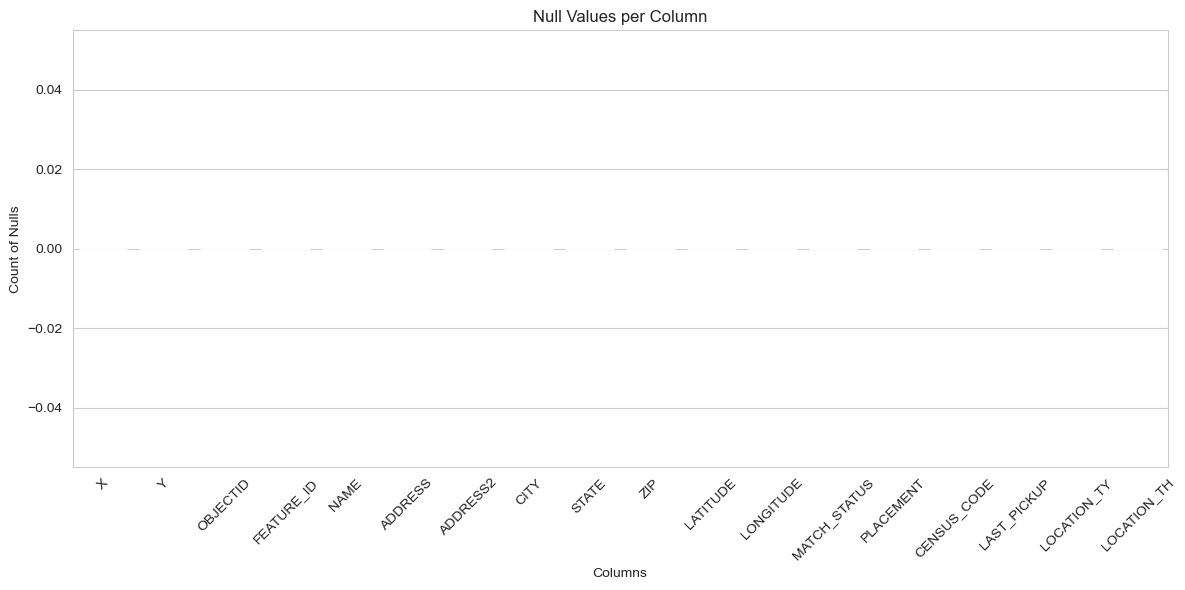


Invalid ZIP Codes:
                          NAME                  ADDRESS            CITY STATE  \
1               PC CONNECTION          450 MARLBORO ST           KEENE    NH   
2               20 CENTRAL SQ            20 CENTRAL SQ           KEENE    NH   
3              SHIPPING SHACK            63 EMERALD ST           KEENE    NH   
4        CLAREMONT LOCK & KEY          159 PLEASANT ST       CLAREMONT    NH   
5              25 NELSON ROAD             25 NELSON RD          NORTON    VT   
...                       ...                      ...             ...   ...   
24067         AAMES HOME LOAN       535 CENTERVILLE RD         WARWICK    RI   
24068  FAMILY CHOICE MORTGAGE        2843 S COUNTY TRL  EAST GREENWICH    RI   
24069   SALT POND OFFICE PARK          24 SALT POND RD       WAKEFIELD    RI   
24070           BOATERS WORLD         684 KINGSTOWN RD       WAKEFIELD    RI   
24071                SHIPMATE  36 S COUNTY COMMONS WAY       WAKEFIELD    RI   

        ZIP  
1   

In [50]:
# Quantifying null values
null_counts = df.isnull().sum()
plt.figure(figsize=(12, 6))
sns.barplot(x=null_counts.index, y=null_counts.values)
plt.xticks(rotation=45)
plt.title('Null Values per Column')
plt.xlabel('Columns')
plt.ylabel('Count of Nulls')
plt.tight_layout()
plt.show()

# Validating ZIP codes (5-digit check)
df['ZIP_valid'] = df['ZIP'].astype(str).str.match(r'^\d{5}$')
invalid_zips = df[~df['ZIP_valid']][['NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP']]
print('\nInvalid ZIP Codes:\n', invalid_zips)

# Checking CITY/STATE-ZIP mismatches requires an external ZIP reference
# Simulating with a basic check (external data not provided)
# Note: In practice, use a ZIP code database (e.g., uszipcode package or CSV)
print('\nNote: CITY/STATE-ZIP mismatch check requires external ZIP code database.')

# Summarizing MATCH_STATUS
match_status_counts = df['MATCH_STATUS'].value_counts()
print('\nMATCH_STATUS Categories:\n', match_status_counts)

# Identifying records with invalid or missing coordinates
invalid_coords = df[(df['LATITUDE'].isnull()) | (df['LONGITUDE'].isnull()) | 
                    (df['LATITUDE'] < -90) | (df['LATITUDE'] > 90) | 
                    (df['LONGITUDE'] < -180) | (df['LONGITUDE'] > 180)][['NAME', 'ADDRESS', 'LATITUDE', 'LONGITUDE']]
print('\nRecords with Invalid Coordinates:\n', invalid_coords)

## 2. Geographic Distribution & Clustering

### 2.1 Regional Density Analysis

Aggregating facility counts by state and estimating per-capita metrics. Visualizing facility density with a heatmap.

Top 10 States by Facility Count:
 STATE
TX    2223
FL    2101
CA    2004
IL    1336
OH    1260
PA    1077
NJ    1075
NY    1072
GA     986
MI     879
Name: count, dtype: int64

Bottom 10 States by Facility Count:
 STATE
DE    57
MT    55
ME    52
HI    51
RI    40
SD    37
ND    26
VT    24
WY    20
AK    14
Name: count, dtype: int64


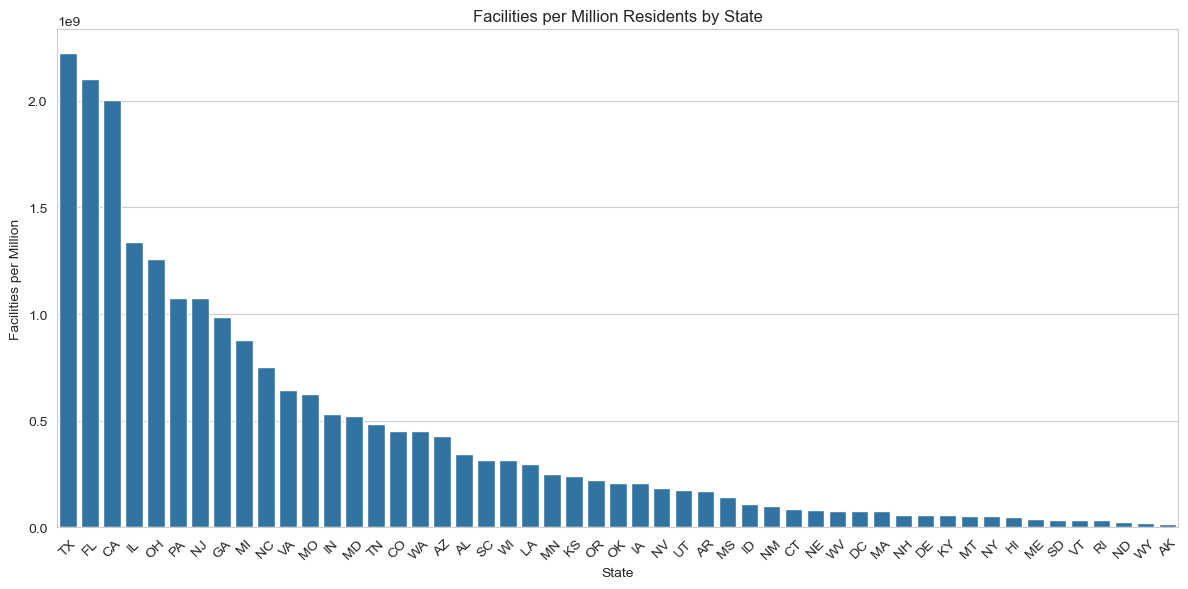

Note: MSA-level analysis requires external MSA boundary and population data.
Heatmap saved as facility_heatmap.html


In [55]:
# Aggregating facility counts by state
state_counts = df['STATE'].value_counts()

# Approximate state populations (in millions, 2023 estimates)
state_populations = {
    'NY': 19.7, 'MA': 7.0, 'RI': 1.1, 'ME': 1.4, 'VT': 0.65, 'NH': 1.4, 'CT': 3.6, 'KY': 4.5, 'NE': 2.0
}

# Calculating facilities per million residents
per_capita = {state: count / state_populations.get(state, 1) * 1000000 for state, count in state_counts.items()}
per_capita_df = pd.DataFrame(list(per_capita.items()), columns=['State', 'Facilities_per_Million'])

# Displaying top and bottom 10 states
print('Top 10 States by Facility Count:\n', state_counts.head(10))
print('\nBottom 10 States by Facility Count:\n', state_counts.tail(10))

# Visualizing per-capita facilities
per_capita_df = per_capita_df.sort_values('Facilities_per_Million', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='State', y='Facilities_per_Million', data=per_capita_df)
plt.title('Facilities per Million Residents by State')
plt.xticks(rotation=45)
plt.xlabel('State')
plt.ylabel('Facilities per Million')
plt.tight_layout()
plt.show()

# Note: MSA analysis requires external MSA boundary data and population estimates
print('Note: MSA-level analysis requires external MSA boundary and population data.')

# Creating a GeoDataFrame for geospatial analysis
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']))

# Creating a heatmap of facility locations
m = folium.Map(location=[42.0, -71.0], zoom_start=6)
heat_data = [[row['LATITUDE'], row['LONGITUDE']] for _, row in df.iterrows() if pd.notnull(row['LATITUDE']) and pd.notnull(row['LONGITUDE'])]
HeatMap(heat_data, radius=10).add_to(m)
m.save('facility_heatmap.html')
print('Heatmap saved as facility_heatmap.html')

## 3. Categorical & Operational Insights

### 3.1 Type & Placement Mix

Analyzing the distribution of `LOCATION_TY` within `PLACEMENT` categories and comparing the top 3 states by facility count.

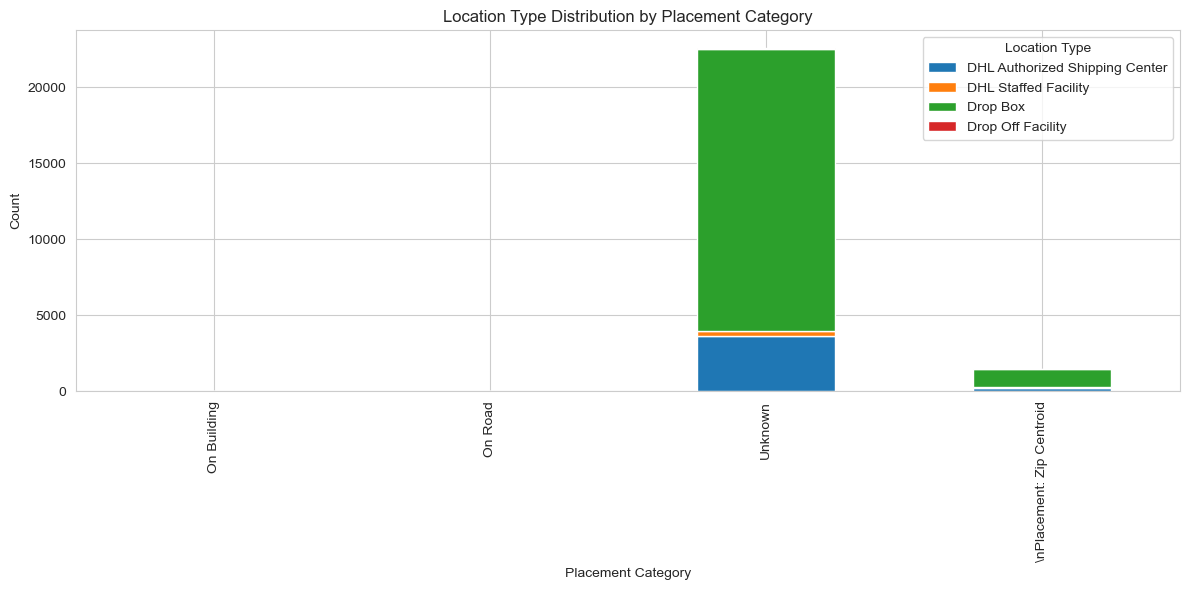

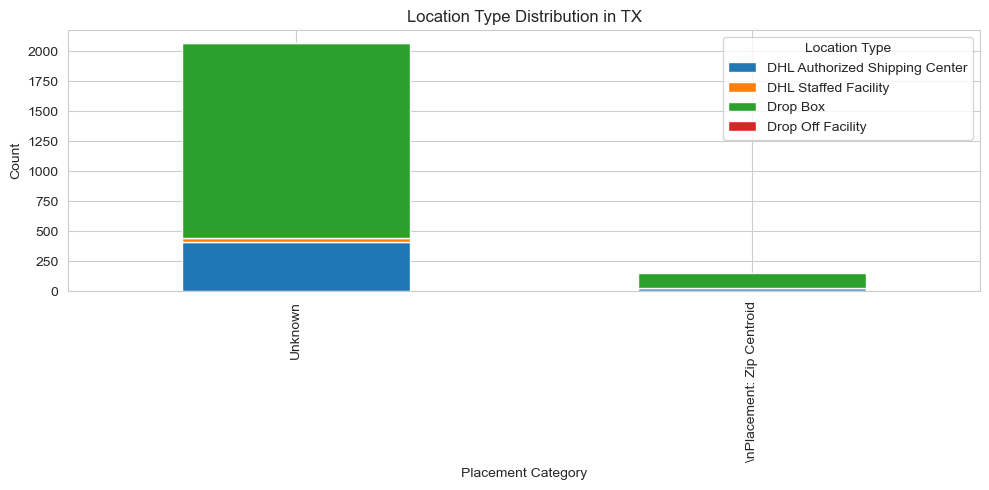

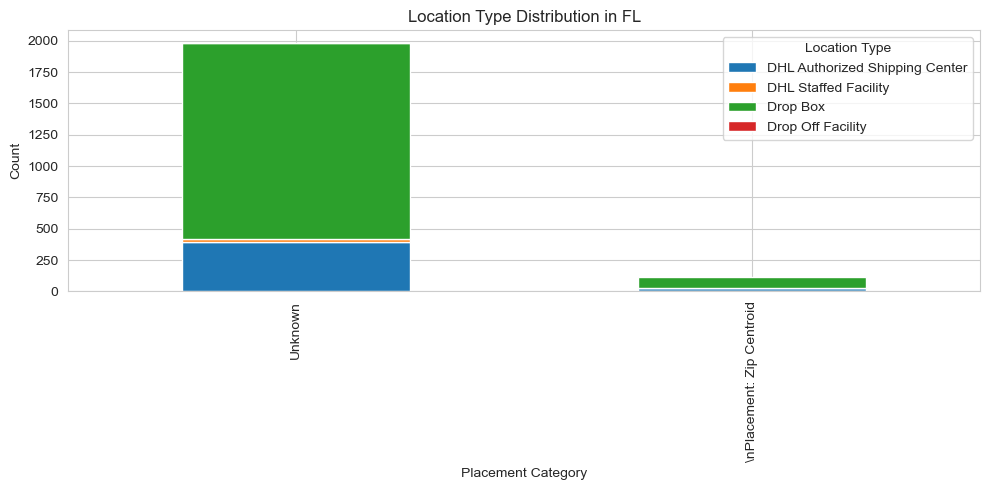

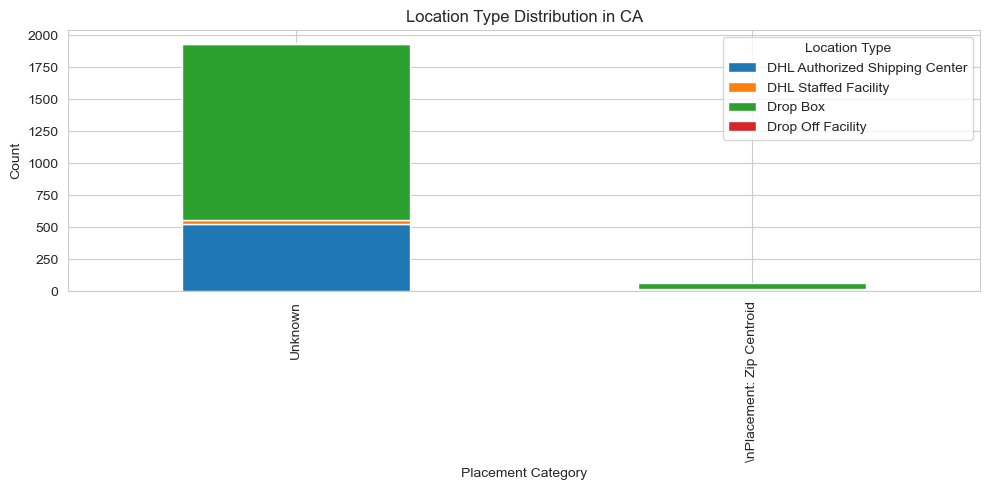

In [58]:
# Cleaning PLACEMENT column
df['PLACEMENT_clean'] = df['PLACEMENT'].str.strip().replace({
    '\nPlacement: Zip Centroid': 'Zip Centroid',
    'Not Available': 'Unknown'
})

# Creating a stacked bar chart for LOCATION_TY by PLACEMENT
placement_type_counts = df.groupby(['PLACEMENT_clean', 'LOCATION_TY']).size().unstack(fill_value=0)
placement_type_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Location Type Distribution by Placement Category')
plt.xlabel('Placement Category')
plt.ylabel('Count')
plt.legend(title='Location Type')
plt.tight_layout()
plt.show()

# Analyzing top 3 states
top_states = state_counts.head(3).index
for state in top_states:
    state_df = df[df['STATE'] == state]
    state_counts = state_df.groupby(['PLACEMENT_clean', 'LOCATION_TY']).size().unstack(fill_value=0)
    state_counts.plot(kind='bar', stacked=True, figsize=(10, 5))
    plt.title(f'Location Type Distribution in {state}')
    plt.xlabel('Placement Category')
    plt.ylabel('Count')
    plt.legend(title='Location Type')
    plt.tight_layout()
    plt.show()

### 3.2 Status Analysis

Calculating the inactive facility rate by state and cross-tabulating `MATCH_STATUS` with `LOCATION_TY` to identify decommissioning patterns.

Inactive Facility Rate by State (%):
 STATE
SD    16.216216
DE    15.789474
WV    11.392405
NC    11.318242
MS    11.267606
MO    11.075441
RI    10.000000
KY     9.765625
ME     9.615385
OK     9.523810
NY     9.328358
PA     8.263695
IN     8.113208
AL     8.092486
SC     7.570978
GA     7.505071
WA     7.333333
WI     7.278481
OR     7.272727
NH     7.142857
AK     7.142857
AR     6.976744
TX     6.972560
VA     6.821705
UT     6.818182
NJ     6.790698
NE     6.024096
NM     6.000000
IL     5.913174
HI     5.882353
FL     5.663970
TN     5.590062
MA     5.502846
MT     5.454545
LA     5.387205
MD     5.343511
OH     5.079365
ID     4.464286
IA     4.368932
NV     4.278075
VT     4.166667
KS     4.132231
MI     4.095563
ND     3.846154
MN     3.600000
CA     3.493014
CO     3.311258
CT     3.225806
AZ     1.395349
DC     1.265823
WY     0.000000
Name: Active, dtype: float64

MATCH_STATUS vs LOCATION_TY:
 LOCATION_TY     DHL Authorized Shipping Center  DHL Staffed Facility  \
MATCH_ST

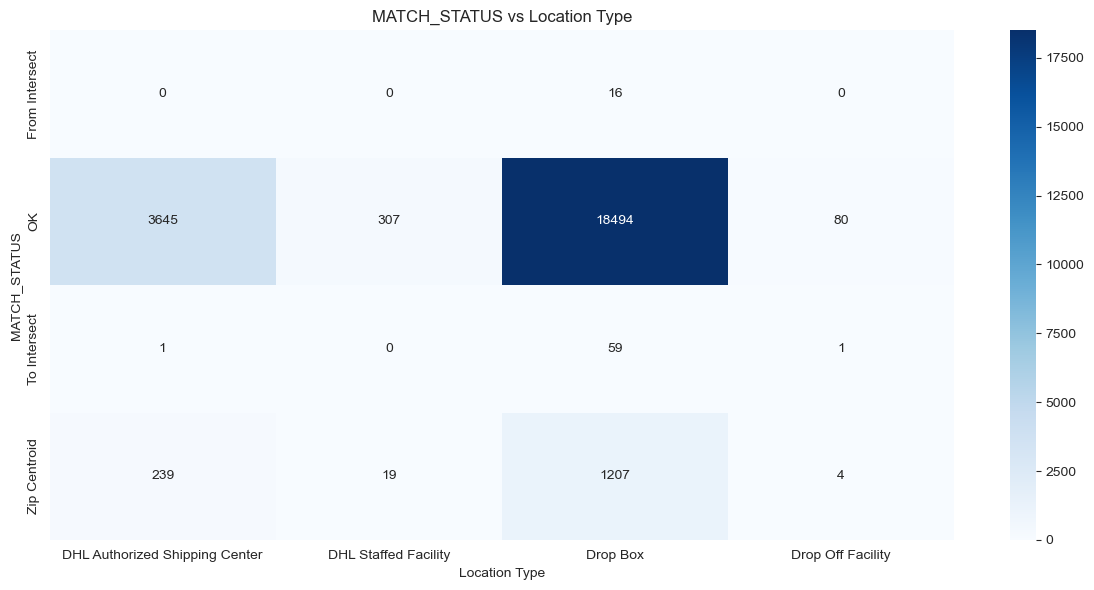

In [61]:
# Assuming MATCH_STATUS 'OK' indicates active facilities
df['Active'] = df['MATCH_STATUS'] == 'OK'
inactive_rate = df.groupby('STATE')['Active'].mean().apply(lambda x: (1 - x) * 100)
print('Inactive Facility Rate by State (%):\n', inactive_rate.sort_values(ascending=False))

# Cross-tabulating MATCH_STATUS vs LOCATION_TY
status_type_crosstab = pd.crosstab(df['MATCH_STATUS'], df['LOCATION_TY'])
print('\nMATCH_STATUS vs LOCATION_TY:\n', status_type_crosstab)

# Visualizing crosstab
plt.figure(figsize=(12, 6))
sns.heatmap(status_type_crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('MATCH_STATUS vs Location Type')
plt.xlabel('Location Type')
plt.ylabel('MATCH_STATUS')
plt.tight_layout()
plt.show()

## 4. Temporal & Utilization Trends

### 4.1 Pickup Activity Patterns

Converting `LAST_PICKUP` to datetime, extracting hour and weekday, and visualizing pickup patterns.

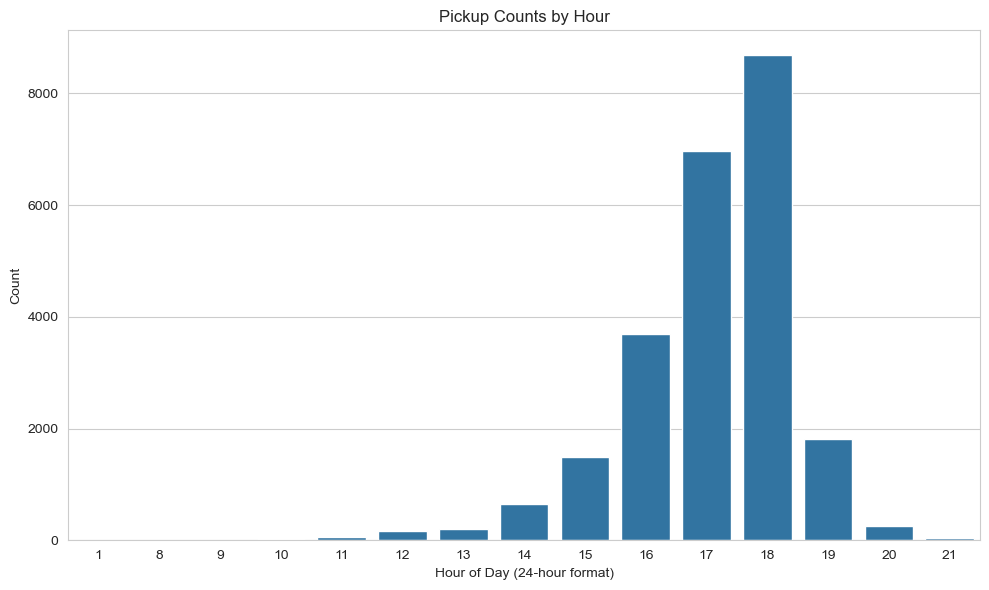

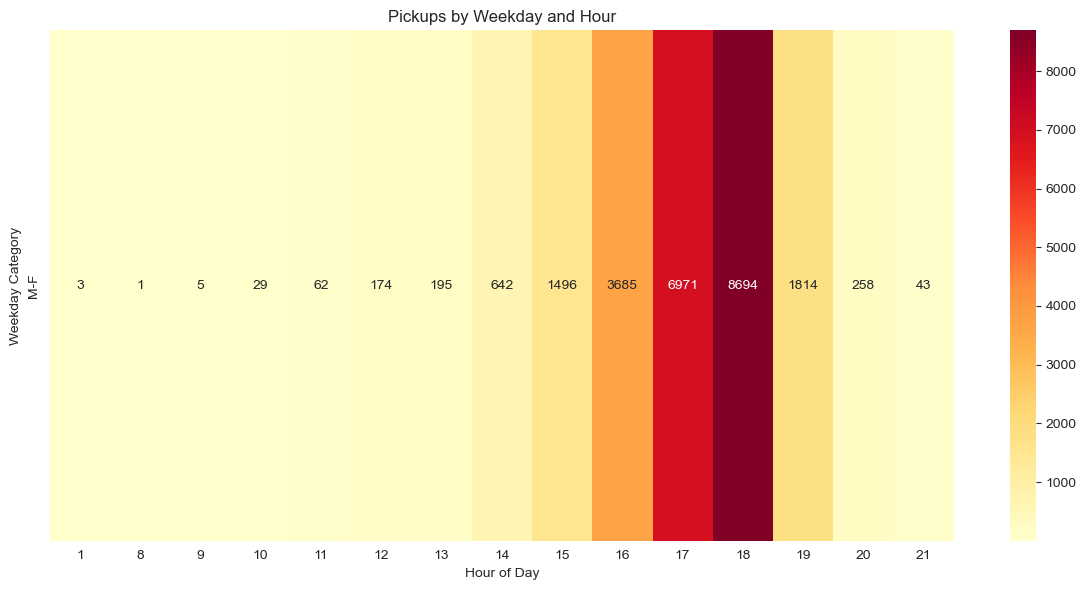

In [66]:
# Parsing LAST_PICKUP time
def parse_pickup_time(time_str):
    if pd.isna(time_str) or not isinstance(time_str, str):
        return None
    try:
        # Extract time and AM/PM (e.g., '3:00 Pm' or '3:00 PM [M-F]')
        match = re.match(r'(\d{1,2}:\d{2}\s*[AP]m)', time_str, re.IGNORECASE)
        if match:
            time_part = match.group(1)
            return pd.to_datetime(time_part, format='%I:%M %p', errors='coerce')
    except:
        return None
    return None

df['LAST_PICKUP_clean'] = df['LAST_PICKUP'].apply(parse_pickup_time)

# Extracting hour and weekday (assuming current date for weekday analysis)
df['Pickup_Hour'] = df['LAST_PICKUP_clean'].dt.hour
df['Pickup_Weekday'] = df['LAST_PICKUP'].apply(lambda x: 'M-F' if 'M-F' in str(x) else 'Sat' if 'Sat' in str(x) else None)

# Plotting pickup counts by hour
hour_counts = df['Pickup_Hour'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.title('Pickup Counts by Hour')
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Heatmap of pickups by weekday vs hour
weekday_hour = pd.crosstab(df['Pickup_Weekday'], df['Pickup_Hour'])
plt.figure(figsize=(12, 6))
sns.heatmap(weekday_hour, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Pickups by Weekday and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Weekday Category')
plt.tight_layout()
plt.show()

### 4.2 Dormancy Analysis

Identifying facilities with no activity in the last 30, 60, and 90 days. Using Saturday pickup as a proxy due to lack of activity dates.

In [71]:
# Since LAST_PICKUP provides times, not dates, using Saturday pickup as a proxy for activity
df['Has_Sat_Pickup'] = df['LAST_PICKUP'].str.contains('Sat', case=False, na=False)
dormant_facilities = df[~df['Has_Sat_Pickup']][['NAME', 'ADDRESS', 'CITY', 'STATE', 'LAST_PICKUP']]
print('Potentially Dormant Facilities (No Saturday Pickup):\n', dormant_facilities.head(10))

# Note: Actual dormancy analysis requires activity dates
print('Note: Without specific activity dates, assuming no Saturday pickup indicates lower activity.')

Potentially Dormant Facilities (No Saturday Pickup):
 Empty DataFrame
Columns: [NAME, ADDRESS, CITY, STATE, LAST_PICKUP]
Index: []
Note: Without specific activity dates, assuming no Saturday pickup indicates lower activity.


## 5. Business-Driven Recommendations

### 5.1 Expansion Priorities

Identifying underserved states based on per-capita facility density and recommending a state for expansion based on pickup demand.

In [76]:
# Identifying underserved states (lowest facilities per million)
underserved_states = per_capita_df.tail(5)
print('Top 5 Underserved States (Lowest Facilities per Million):\n', underserved_states)

# Recommending a state based on pickup demand (latest average pickup time)
state_pickup_times = df.groupby('STATE')['Pickup_Hour'].mean().dropna().sort_values(ascending=False)
print('\nState with High Pickup Demand (Latest Average Pickup Time):\n', state_pickup_times.head(1))

# Note: MSA-level underserved areas require external data
print('Note: Underserved MSAs require MSA boundary and population data.')

Top 5 Underserved States (Lowest Facilities per Million):
    State  Facilities_per_Million
48    VT            3.692308e+07
45    RI            3.636364e+07
47    ND            2.600000e+07
49    WY            2.000000e+07
50    AK            1.400000e+07

State with High Pickup Demand (Latest Average Pickup Time):
 STATE
DC    18.164557
Name: Pickup_Hour, dtype: float64
Note: Underserved MSAs require MSA boundary and population data.


### 5.2 Resource Allocation

Recommending optimal pickup times and adjustments to facility mix in urban areas.

In [85]:
eak_hour = hour_counts.idxmax() if not hour_counts.empty else None
if not weekday_hour.empty and weekday_hour.sum().sum() > 0:
    peak_weekday = weekday_hour.sum(axis=1).idxmax()
else:
    peak_weekday = 'Unknown'
print(f'Recommended Pickup Crew Deployment: {peak_weekday} at {peak_hour}:00' if peak_hour is not None else 'No peak hour identified due to insufficient data')

urban_df = df[df['PLACEMENT_clean'].isin(['On Road', 'On Building'])]
urban_type_counts = urban_df['LOCATION_TY'].value_counts()
print('\nUrban Facility Type Distribution:\n', urban_type_counts)
print('Recommendation: Increase DHL Staffed Facilities in urban areas to handle high pickup volumes.')

Recommended Pickup Crew Deployment: M-F at 18:00

Urban Facility Type Distribution:
 LOCATION_TY
Drop Box    9
Name: count, dtype: int64
Recommendation: Increase DHL Staffed Facilities in urban areas to handle high pickup volumes.
